In [1]:
import matplotlib.pyplot as plt
import math
import numpy as np
import scipy.io
import cmocean 
import sys
sys.path.insert(1, '/Users/emmagurcan/Documents/France/ENS/M1/stageM1/analysis')
from functions_MSM74 import *
import fonctions as f
import matplotlib.ticker as ticker
import netCDF4 as nc
import cartopy.crs as ccrs
import gsw
from scipy.spatial import cKDTree
from scipy import interpolate
from scipy.interpolate import griddata
from matplotlib.colors import Normalize

In [2]:
woa_path_long = "/Users/emmagurcan/Documents/France/ENS/M1/stageM1/data/woa/woa23_decav_s08_01.nc"
woa_salinity_path_long = "/Users/emmagurcan/Documents/France/ENS/M1/stageM1/data/woa/woa23_decav91C0_t08_01.nc"

woa_salinity_path = "/Users/emmagurcan/Documents/France/ENS/M1/stageM1/data/woa/2015-2022_mean/woa23_B5C2_t08_01.nc"
woa_path = "/Users/emmagurcan/Documents/France/ENS/M1/stageM1/data/woa/2015-2022_mean/woa23_decav_s08_01.nc"
raw_ctd = "/Users/emmagurcan/Documents/France/ENS/M1/stageM1/data/Data_MSM74/raw_ctd.nc"
clean = "/Users/emmagurcan/Documents/France/ENS/M1/stageM1/data/Data_MSM74/clean_ctd.nc"
clean_lonlat = "/Users/emmagurcan/Documents/France/ENS/M1/stageM1/data/Data_MSM74/clean_lonlatev.nc"
nclonlat = "/Users/emmagurcan/Documents/France/ENS/M1/stageM1/data/Data_MSM74/MSM74_lonlat.nc"
readcp = "/Users/emmagurcan/Documents/France/ENS/M1/stageM1/data/Data_MSM74/MSM74-VMADCP_allfiles/msm_074_1_vmadcp_75khz_01.nc"
rep = "/Users/emmagurcan/Documents/France/ENS/M1/stageM1/data/Data_MSM74/MSM74_CTD.tab"
lon_lat_event = "/Users/emmagurcan/Documents/France/ENS/M1/stageM1/data/Data_MSM74/lon_lat_event.nc"


In [3]:
ds = nc.Dataset(woa_path)
dss = nc.Dataset(woa_salinity_path)
# ds14 = nc.Dataset(woa_path14)
ds_adcp = nc.Dataset(readcp)
ds_ctd = nc.Dataset(clean)
lonlatev = nc.Dataset(clean_lonlat)

In [4]:
rep = '/Users/emmagurcan/Documents/France/ENS/M1/stageM1'
uCTD = scipy.io.loadmat(rep+'/Data/Data_MSM40/UCTD_dataproc.mat')
adcp = scipy.io.loadmat(rep +'/Data/Data_MSM40/adcp_150kHz/TL_GEOMAR_150_STJOHNS_BREST_000_000000_6_hc.mat')

In [5]:
# Define the section (section 2 can't be plotted => no uCTD measures)
section_num = 4
sub_section = 1
start_index, end_index, len_section, start_index_adcp, end_index_adcp = f.section(section_num)
name = f'section_{section_num}'
# inv_x = 0
if section_num == 4:
    inv_x = 1
cruise = "MSM40"
set_maxdepth(cruise)
extent=[-70, -25, 50, 70]
if sub_section < 3:
    extent=[-70, -15, 50, 70]
if section_num == 1:
    extent=[-70, -25, 40, 70]

In [6]:
# Define depth limit for uCTD
depth_max=300

# Define depth limit for ADCP
depth_max_adcp=300

# Create depth array
depth = np.arange(0, 1001)

In [7]:
# CTD data
lon = np.squeeze(uCTD['uctdlon'])[start_index:end_index+1]
lat = np.squeeze(uCTD['uctdlat'])[start_index:end_index+1]
PT = np.squeeze(uCTD['PTgrid'])[:,start_index:end_index+1]
PD = np.squeeze(uCTD['PDgrid'])[:,start_index:end_index+1]
S = np.squeeze(uCTD['Sgrid'])[:,start_index:end_index+1]


# Select adcp data
b = adcp['b']
bb = b[0,0]
ref = bb[0][0,0][0]
nav = bb[2][0,0][0]
vel = bb[1]
u = vel[:,0,:] + ref[0,:] # vitesse zonale, positive vers l'est
v = vel[:,1,:] + ref[1,:] # vitesse méridionale, positive vers le nord
depth_adcp = bb[3][0]
LON_adcp = nav[1,:]
LAT_adcp = nav[2,:]
lat_adcp_section = LAT_adcp[start_index_adcp:end_index_adcp+1]
lon_adcp_section = LON_adcp[start_index_adcp:end_index_adcp+1]
u_adcp = u[:,start_index_adcp:end_index_adcp+1]
v_adcp = v[:,start_index_adcp:end_index_adcp+1]

if section_num == 7:
    splits = np.linspace(np.max(lon), np.min(lon), 4)
    start = splits[sub_section - 1]
    stop = splits[sub_section]
    valid_ctd = np.where(np.logical_and(lon < start, lon > stop))
    lon = lon[valid_ctd]
    lat = lat[valid_ctd]
    PT = PT[:, valid_ctd].squeeze()
    PD = PD[:, valid_ctd].squeeze()
    S = S[:, valid_ctd].squeeze()
    valid_adcp = np.where(np.logical_and(lon_adcp_section < start, lon_adcp_section > stop))
    lat_adcp_section = lat_adcp_section[valid_adcp]
    lon_adcp_section = lon_adcp_section[valid_adcp]
    u_adcp = u_adcp[:, valid_adcp].squeeze()
    v_adcp = v_adcp[:, valid_adcp].squeeze()

In [8]:
# Calculate distances
d1 = np.sin(lat*(math.pi/180))*np.sin(lat[0]*(math.pi/180))
d2 = np.cos(lat*(math.pi/180))*np.cos(lat[0]*(math.pi/180)) * \
    np.cos(abs(lon[0]-lon)*(math.pi/180))
distance = 6371*np.arccos(d1+d2)

d1_adcp = np.sin(lat_adcp_section*(math.pi/180))*np.sin(lat_adcp_section[0]*(math.pi/180))
d2_adcp = np.cos(lat_adcp_section*(math.pi/180))*np.cos(lat_adcp_section[0]*(math.pi/180)) * \
    np.cos(abs(lon_adcp_section[0]-lon_adcp_section)*(math.pi/180))
distance_adcp = 6371*np.arccos(d1_adcp+d2_adcp)

v_ortho = calc_ortho_vel(section_num, cruise, lon_adcp_section, lat_adcp_section, u_adcp, v_adcp)
mdepth = get_maxdepth()
# depth_adcp = np.linspace(0, depth_max_adcp, 37)


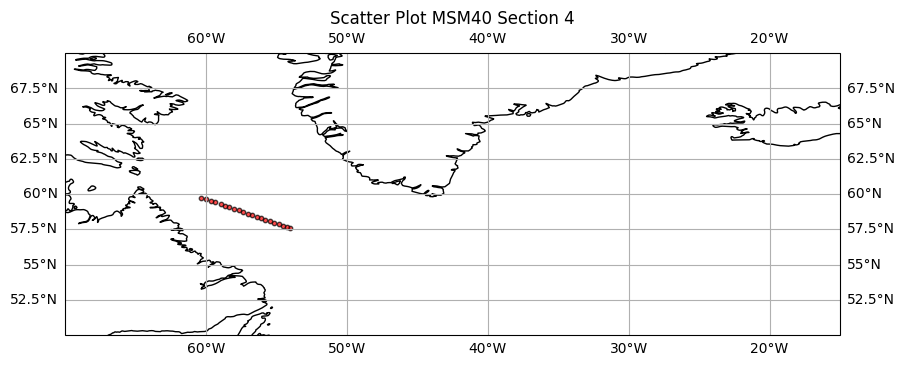

In [9]:
plot_coords(lon, lat, title=f"Scatter Plot MSM40 Section {section_num}", extent=extent)

In [10]:
t_grid = PT
s_grid = S
sigma_grid = PD
des = np.linspace(0, mdepth, mdepth)

In [11]:
# Reference profile
lon_woa = ds['lon']
lat_woa = ds['lat']
# t_an = np.squeeze(ds['t_an'])
# t_an14 = np.squeeze(ds['t_an'])
t_mn = np.squeeze(dss['t_mn'])
s_mn = np.squeeze(ds['s_mn'])
depth_woa = ds['depth']
print(lon_woa.shape)
# print(t_an.shape)

(360,)


In [12]:
tref, lon_woa_sel, lat_woa_sel = get_woa_ref(lon, lat, lon_woa, lat_woa, t_mn)
sref, lon_woa_sels, lat_woa_sels = get_woa_ref(lon, lat, lon_woa, lat_woa, s_mn)
print(lon_woa_sel)
print(lat_woa_sel)


-57.5
58.5


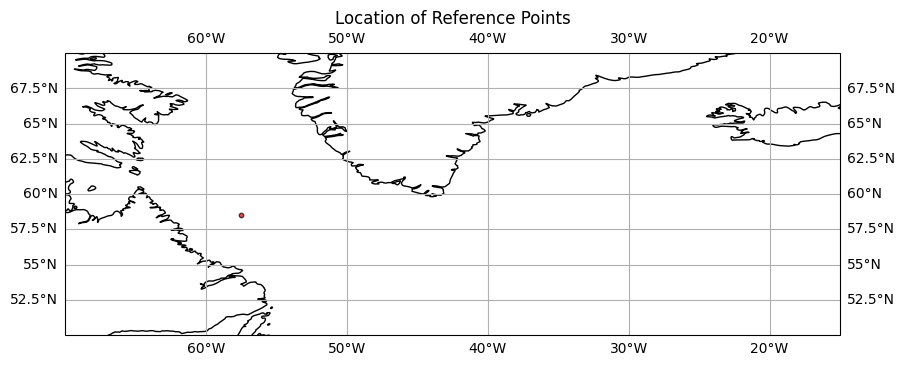

In [13]:
plot_coords(lon_woa_sel, lat_woa_sel, title="Location of Reference Points", extent=extent)

In [14]:
no_lon = [-20.5, -21.5, -20.5]
no_lat = [55.5, 55.5, 54.5]
tref, lon_woa_sel, lat_woa_sel = get_alternate_woa_ref(lon, lat, lon_woa, lat_woa, t_mn, no_lon, no_lat)
sref, lon_woa_sels, lat_woa_sels = get_alternate_woa_ref(lon, lat, lon_woa, lat_woa, s_mn, no_lon, no_lat)
print(lon_woa_sel)
print(lat_woa_sel)

-57.5
58.5


In [15]:
print(lon_woa_sel)
print(lat_woa_sel)

-57.5
58.5


In [16]:
mdepth = get_maxdepth()
ndepth = get_numdepth()
depth_idxs = np.where(depth_woa[:] <= mdepth)
depth_woa = depth_woa[:]
tref_profile = tref[:]
sref_profile = sref[:]

woa_press = gsw.p_from_z(-depth_woa, lat_woa_sels)
# print(lat_woa_sels)

sigma_woa = determine_sigma(sref_profile, tref_profile, woa_press, lon_woa_sels, lat_woa_sels)


In [17]:
# import numpy as np
# import scipy.interpolate as interpolate
# import gsw


In [18]:
depth_woa.shape

(57,)

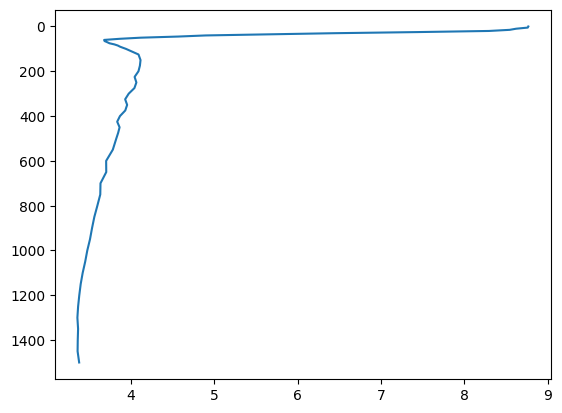

In [19]:
plt.plot(tref, depth_woa)
plt.gca().invert_yaxis()

In [20]:
anomalyt, ind_X, ind_Z = anom(tref, sref, lon_woa_sel, lat_woa_sel, depth_woa, t_grid, s_grid, sigma_grid, distance, "temperature", pas=0.0001)
anomalys, ind_X, ind_Z = anom(tref, sref, lon_woa_sel, lat_woa_sel, depth_woa, t_grid, s_grid, sigma_grid, distance, "salinity", pas=0.0001)
anomalyp, ind_X, ind_Z = anom(tref, sref, lon_woa_sel, lat_woa_sel, depth_woa, t_grid, s_grid, sigma_grid, distance, "density")

Calculating Temperature Anomalies
Calculating Salinity Anomalies
Calculating Density Anomalies
300.0
0.0


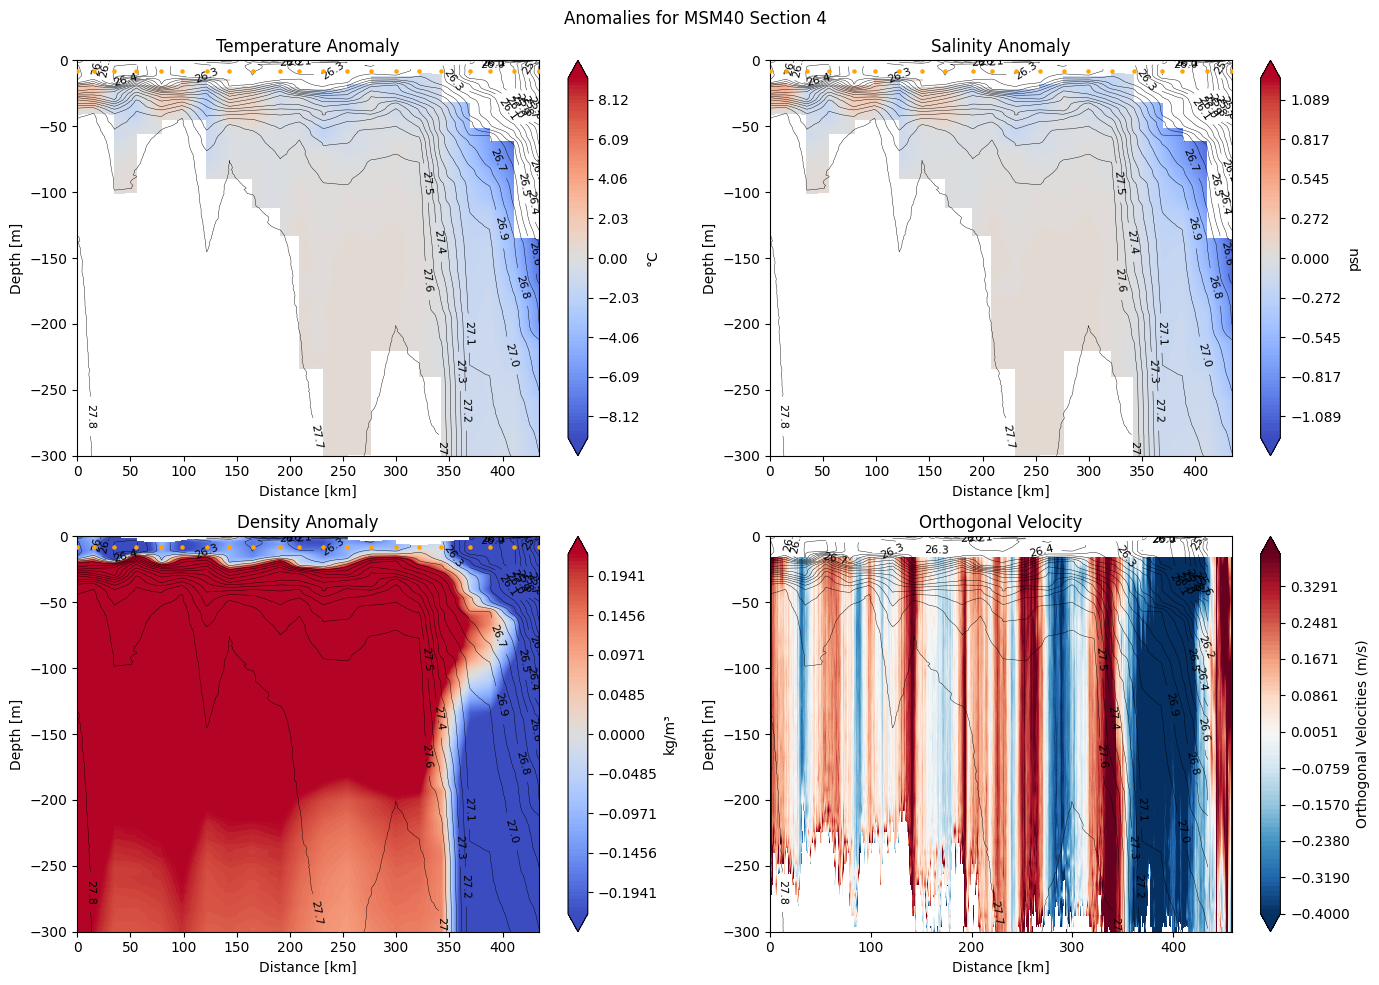

In [21]:
plot_anomalies(distance, ind_Z, anomalyt, anomalys, anomalyp, depth, sigma_grid, v_ortho, depth_adcp, distance_adcp, section_num, saturation=1.1, saturationd = 0.17, inv_x=0, cruise="MSM40")